In [64]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Setting the seed for reproducibility
seed = 42
np.random.seed(seed)


In [65]:
# Set the paths based on your Drive directory
data_dir ='data' # Change to the path to your directory
train_images_dir = os.path.join(data_dir, 'Training')
test_images_dir = os.path.join(data_dir, 'Testing')

In [66]:
print(f"Data directory: {data_dir}")
print(f"Training directory: {train_images_dir}")
print(f"Testing directory: {test_images_dir}")


Data directory: data
Training directory: data/Training
Testing directory: data/Testing


In [67]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.
def add_noise(img):
    std_coeff = 70*np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

image_res = 30
def get_images(train_dir: str, test_dir: str):
    datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise)

    img_height, img_width = image_res, image_res
    batch_size = 32

    # Load training data
    train_data = datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        color_mode='grayscale',
        #seed=seed
    )

    # Load test data
    test_data = datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        color_mode='grayscale'
    )

    return train_data, test_data

# Load the training and test data
try:
    train_data, test_data = get_images(train_images_dir, test_images_dir)
    print("Data loading completed successfully.")
    print(f"Number of training samples: {train_data.samples}")
    print(f"Number of test samples: {test_data.samples}")
    print(f"Class names: {train_data.class_indices}")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


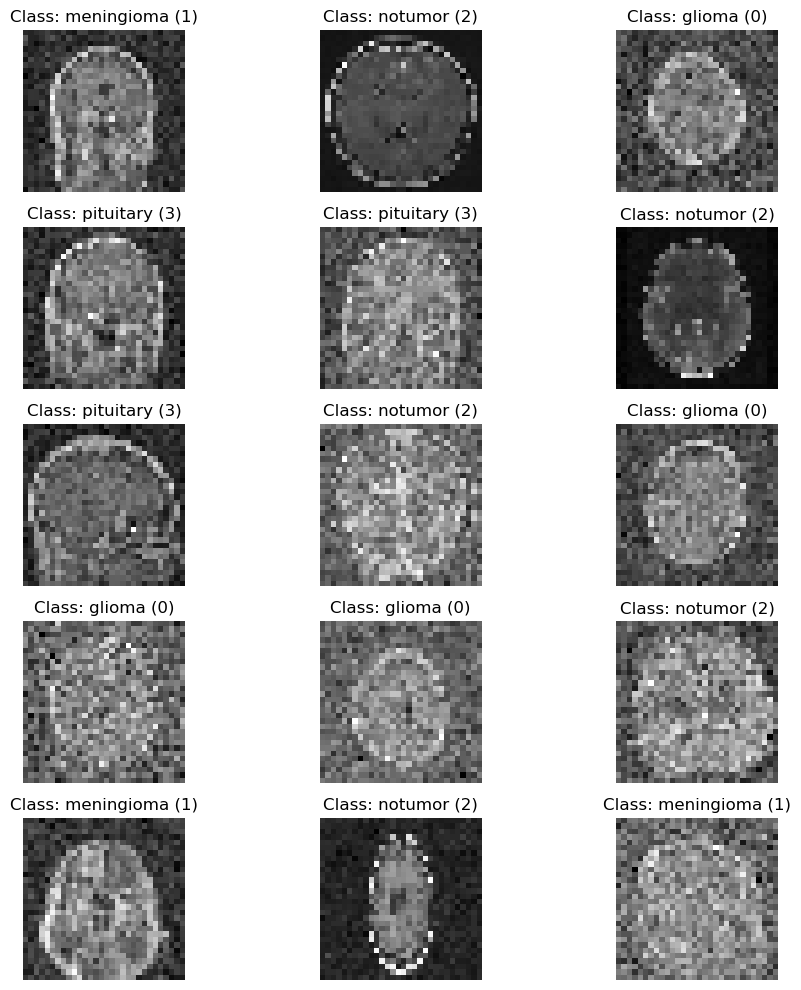

In [68]:
def visualize_batch(df):

    #Iterating through the different batches
    image_batch, label_batch = next(df)

    #Deriving the class names
    class_names = train_data.class_indices

    #Creating 1 figure with 15 subplots
    fig, ax = plt.subplots(nrows= 5, ncols = 3, figsize = (10, 10))

    #Flatten the axis allowing for easier assignment of 'i'
    ax = ax.flatten()
    for i in range(15):

        #For every ax[i], display the image on the index
        ax[i].imshow(image_batch[i], cmap = 'gray')
        ax[i].axis('off')

        #Deriving the class number and class name
        class_number = label_batch[i].argmax()

        #Displaying the class name and its corresponding number
        for name, number in class_names.items():

            #Checking which number corresponds to the class number
            if number == class_number:
                class_name = name
                ax[i].set_title(f'Class: {class_name} ({class_number})')

    plt.tight_layout()
    plt.show()

visualize_batch(train_data)


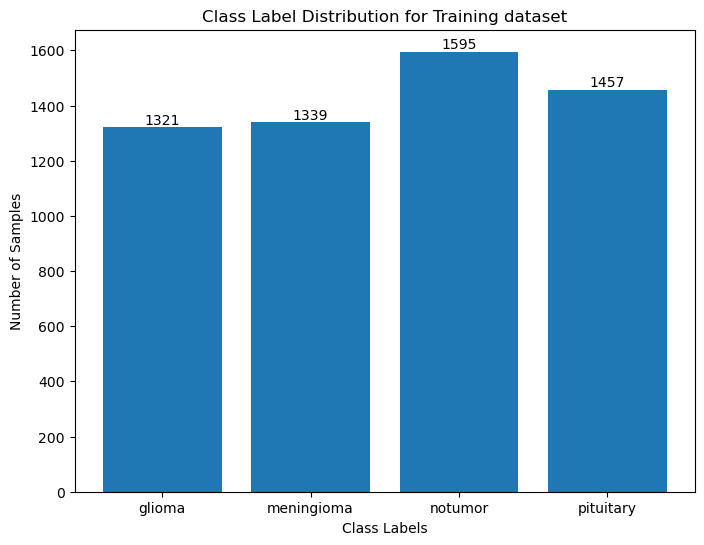

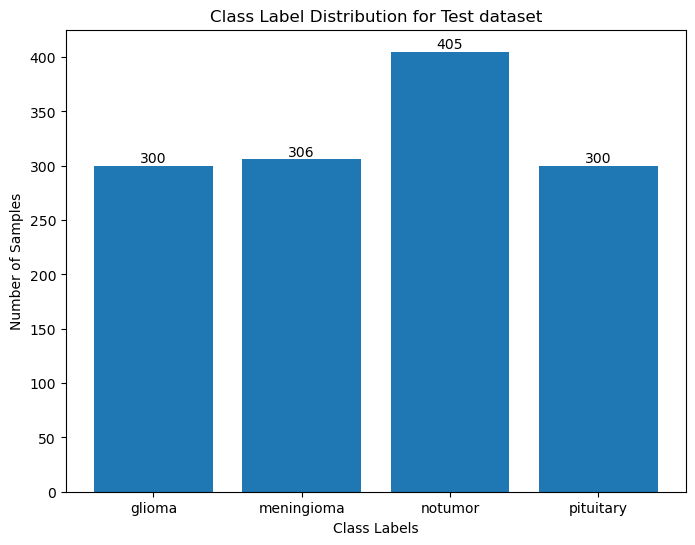

In [69]:
for data in [("Training", train_data), ("Test", test_data)]:
  class_labels = list(data[1].class_indices.keys())

  class_counts = [np.sum(data[1].labels == i) for i in range(len(class_labels))]

  plt.figure(figsize=(8, 6))
  bars = plt.bar(class_labels, class_counts)
  plt.xlabel("Class Labels")
  plt.ylabel("Number of Samples")
  plt.title(f"Class Label Distribution for {data[0]} dataset")

  for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')


In [70]:
def train_val_split(df,val_split = 0.2):
    #Resetting the generator for reproducible results
    df.reset()

    n_batches = df.num_batches
    batch_size = df.batch_size
    n_samples = df.samples

    print(f'Number of batches in the training data: {n_batches}')
    print(f'Batch size of a single batch {batch_size}')
    print(f'Number of samples in the training dataset {n_samples}')
    print()

    #Setting the size of the train and validation set according to the required split and testing if all batches are included
    val_batches = int(n_batches * val_split)
    train_batches = n_batches - val_batches

    print(f'Number of training data batches with val split of {val_split}: {train_batches}')
    print(f'Number of validation data batches: {val_batches}')
    print()
    assert train_batches + val_batches == n_batches, 'Train and val batches do not add up to total n batches'




    #Iterating through the batches and appending them into lists for train and val
    x_train, y_train = list(), list()
    x_val, y_val = list(), list()

    for batch in range(n_batches):
        x, y = next(df)
        if batch < train_batches:
            x_train.append(x)
            y_train.append(y)

        else:
            x_val.append(x)
            y_val.append(y)

    assert len(x_train) + len(x_val) == n_batches, 'Error in dividing batches into train and val sets'


    #Converting the lists into arrays suited for Tensorflow
    x_train = tf.concat(x_train, axis = 0)
    y_train = tf.concat(y_train, axis = 0)
    x_val = tf.concat(x_val, axis = 0)
    y_val = tf.concat(y_val, axis = 0)

    print(f'Shape of image training set: {x_train.shape}')
    print(f'Shape of image validation set: {x_val.shape}')
    print()
    print(f'Shape of label training set: {y_train.shape}')
    print(f'Shape of label validation set: {y_val.shape}')

    #Testing to see if all the samples are included
    assert x_train.shape[0] + x_val.shape[0] == n_samples, 'Error, not all samples included'



    return x_train, y_train, x_val, y_val

X_train, y_train, X_val, y_val = train_val_split(train_data)

Number of batches in the training data: 179
Batch size of a single batch 32
Number of samples in the training dataset 5712

Number of training data batches with val split of 0.2: 144
Number of validation data batches: 35

Shape of image training set: (4608, 30, 30, 1)
Shape of image validation set: (1104, 30, 30, 1)

Shape of label training set: (4608, 4)
Shape of label validation set: (1104, 4)


In [71]:
def test_splits(df):
    #Resetting the generator for reproducible results
    df.reset()

    n_batches = df.num_batches
    batch_size = df.batch_size
    n_samples = df.samples

    print(f'Number of batches in the test data: {n_batches}')
    print(f'Batch size of a single batch {batch_size}')
    print(f'Number of samples in the test dataset {n_samples}')
    print()

    #Iterating through the batches and appending them into lists for train and val
    x_test, y_test = list(), list()

    for batch in range(n_batches):
        x, y = next(df)
        x_test.append(x)
        y_test.append(y)

    #Converting the lists into arrays suited for Tensorflow
    x_test = tf.concat(x_test, axis = 0)
    y_test = tf.concat(y_test, axis = 0)

    print(f'Shape of image test set: {x_test.shape}')
    print()
    print(f'Shape of label test set: {y_test.shape}')

    #Testing to see if all the samples are included
    assert  x_test.shape[0] == n_samples, 'Error, not all samples included'
    return x_test, y_test


X_test, y_test = test_splits(test_data)

Number of batches in the test data: 41
Batch size of a single batch 32
Number of samples in the test dataset 1311

Shape of image test set: (1311, 30, 30, 1)

Shape of label test set: (1311, 4)


In [72]:
class_names_train = list(train_data.class_indices.keys())
class_names_test = list(test_data.class_indices.keys())

In [73]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix

import random

seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)


# plot diagnostic learning curves
def summarize_metric(history, metric):
    plt.figure(figsize=(6, 4))
    plt.title('Baseline Model Training and Validation Loss')
    plt.plot(range(1,len(history.history[metric]) + 1),history.history[metric], color='red', label=f'Train {metric}')
    plt.plot(range(1,len(history.history[f'val_{metric}']) + 1),history.history[f'val_{metric}'], color='green', label=f'Validation {metric}')
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.grid(True, which='both', linestyle='-')
    val_metric = history.history[f'val_{metric}']
    if metric == "loss":
        best_epoch = val_metric.index(min(val_metric)) + 1
    else:
        best_epoch = val_metric.index(max(val_metric)) + 1

    plt.scatter(best_epoch, val_metric[best_epoch - 1], color='blue', s=20, label=f'best epoch= {best_epoch}')
    plt.legend(loc='upper right', fontsize='x-small')
    plt.show()
    return



def plot_roc_curve(model, X, y, class_names):
    """
    Plots the ROC curve for the validation set without the macro-average.

    Parameters:
    - model: Trained model used to predict the validation set.
    - X:  feature data.
    - y: True labels for the dataset set.
    - class_names: List of class names for labeling the ROC curve plot.
    """

    # Get model predictions for the validation set
    y_pred = model.predict(X)
    y_true = np.argmax(y, axis=1)

    # Binarize the output for multi-class ROC curve
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    y_pred_bin = y_pred

    # Compute ROC curve and ROC AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(10, 8))

    for i, class_name in enumerate(class_names):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {} (area = {:.2f})'.format(class_name, roc_auc[i]))

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='best')
    plt.show()

    return roc_auc



def plot_confusion_matrix(model, X, y, class_names, normalize=False):
    """
    Generates and plots the confusion matrix.

    Parameters:
    - model: Trained model used to predict the dataset.
    - X: Feature data (validation or test set).
    - y: True labels for the dataset.
    - class_names: List of class names for labeling the confusion matrix.
    - normalize: If True, normalize the confusion matrix by dividing by the sum of rows.
    """
    # Get model predictions
    y_pred = model.predict(X)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Normalize confusion matrix if specified
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)

    # Customize the plot
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.title('Confusion Matrix' + (' (Normalized)' if normalize else ''))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [74]:
from tensorflow.keras import Sequential, Input, layers

def baseline():
    baseline = Sequential()
    baseline.add(Input(shape = (30, 30, 1)))
    baseline.add(layers.Conv2D(32, (3, 3), activation = "relu"))
    baseline.add(layers.MaxPooling2D((2, 2)))
    baseline.add(layers.Conv2D(32, (3, 3), activation = "relu"))
    baseline.add(layers.MaxPooling2D((2, 2)))
    baseline.add(layers.Flatten())
    baseline.add(layers.Dense(32, activation = "relu"))
    baseline.add(layers.Dense(4, activation = "softmax"))
    baseline.compile(optimizer = "adam",
                    loss = "categorical_crossentropy",
                    metrics = ["accuracy"])
    return baseline

In [75]:
base = baseline()
history = base.fit(X_train, y_train, batch_size =32, epochs = 10, validation_data = (X_val, y_val))

Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4383 - loss: 1.1890 - val_accuracy: 0.6739 - val_loss: 0.8467
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7233 - loss: 0.7508 - val_accuracy: 0.7264 - val_loss: 0.7196
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7687 - loss: 0.6301 - val_accuracy: 0.7428 - val_loss: 0.6640
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7925 - loss: 0.5681 - val_accuracy: 0.7464 - val_loss: 0.6359
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8050 - loss: 0.5280 - val_accuracy: 0.7572 - val_loss: 0.6110
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8167 - loss: 0.4956 - val_accuracy: 0.7582 - val_loss: 0.6006
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8263 - loss: 0.4680 - val_accuracy: 0.7582 - val_loss: 0.5977
Epoch 8/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8380 - loss: 0.4410 - val_accuracy: 0.

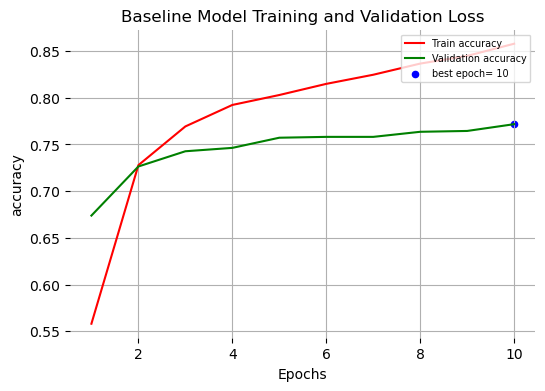

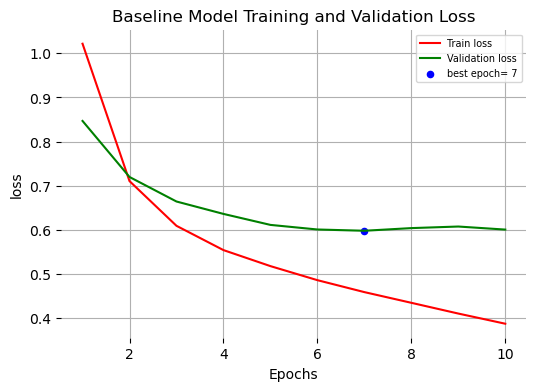

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


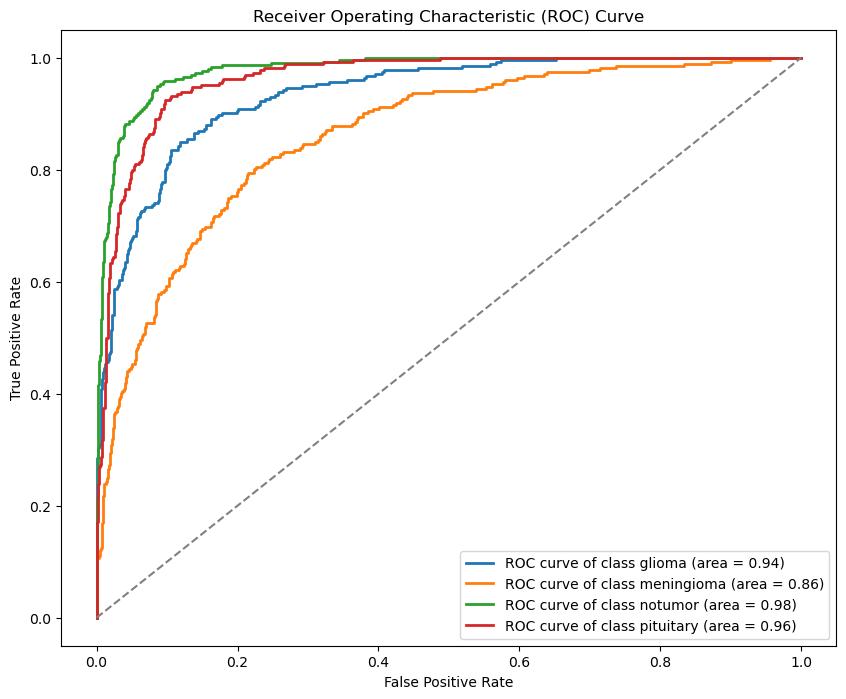

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


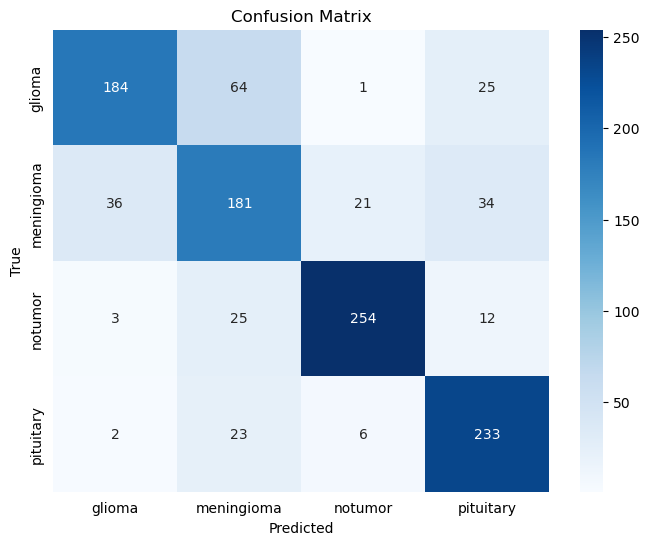

In [76]:
summarize_metric(history, "accuracy")
summarize_metric(history, "loss")

roc_auc_val = plot_roc_curve(base, X_val, y_val, class_names_train)
plot_confusion_matrix(base, X_val, y_val, class_names_train, normalize=False)
